<a href="https://colab.research.google.com/github/cekbote/pytorch-tutorials/blob/master/Image_Classification_using_Logistic_Regression_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Logistic Regression in PyTorch

In [18]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [19]:
# Download training dataset

# When this statement is executed for the first time, it downloads the data to 
# the data/ directory next to the notebook and creates a PyTorch Dataset. On 
# subsequent executions, the download is skipped as the data is already 
# downloaded. Let's check the size of the dataset.

dataset = MNIST(root='data/', download=True)
len(dataset)

60000

In [20]:
# The dataset has 60,000 images which can be used to train the model. There is 
# also an additonal test set of 10,000 images which can be created by passing 
# train=False to the MNIST class.

test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [21]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F9F822E2A20>, 5)

In [22]:
# It's a pair, consisting of a 28x28 image and a label. The image is an object 
# of the class PIL.Image.Image, which is a part of the Python imaging library 
# Pillow. We can view the image within Jupyter using matplotlib, the de-facto 
# plotting and graphing library for data science in Python.

import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


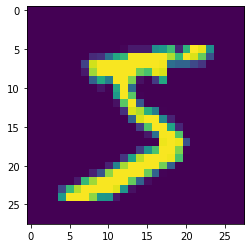

In [23]:
image, label = dataset[0]
plt.imshow(image)
print('Label:', label)

Label: 3


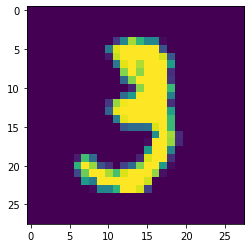

In [24]:
image, label = dataset[10]
plt.imshow(image)
print('Label:', label)

In [25]:
type(image)

PIL.Image.Image

In [26]:
# PyTorch datasets allow us to specify one or more transformation functions 
# which are applied to the images as they are loaded. torchvision.transforms 
# contains many such predefined functions, and we'll use the ToTensor transform 
# to convert images into PyTorch tensors.

import torchvision.transforms as transforms

In [27]:
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

In [28]:
# The first dimension is used to keep track of the color channels.

img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [29]:
# The values range from 0 to 1, with 0 representing black, 1 white and the 
# values in between different shades of grey. We can also plot the tensor as an 
# image using plt.imshow.

print(img_tensor[:, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


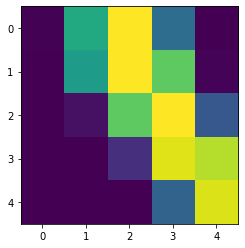

In [30]:
plt.imshow(img_tensor[0, 10:15, 10:15])

In [31]:
# Since there's no predefined validation set, we must manually split the 60,000 
# images into training and validation datasets. Let's set aside 10,000 randomly 
# chosen images for validation. We can do this using the random_spilt method 
# from PyTorch.

from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [32]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle= True)

## Model

- A logistic regression model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

- Just as we did with linear regression, we can use nn.Linear to create the model instead of defining and initializing the matrices manually.

- Since nn.Linear expects the each training example to be a vector, each 1x28x28 image tensor needs to be flattened out into a vector of size 784 (28*28), before being passed into the model.

- The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [33]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic Regression Model
model = nn.Linear(input_size, num_classes)

In [34]:
print(model.weight.shape)
print(model.weight)

torch.Size([10, 784])
Parameter containing:
tensor([[-0.0186,  0.0195,  0.0183,  ...,  0.0114, -0.0328, -0.0329],
        [ 0.0108,  0.0286,  0.0052,  ..., -0.0341, -0.0320, -0.0016],
        [ 0.0079, -0.0114,  0.0080,  ...,  0.0310, -0.0239,  0.0247],
        ...,
        [-0.0349,  0.0325, -0.0343,  ..., -0.0229, -0.0353, -0.0142],
        [ 0.0357, -0.0181, -0.0345,  ..., -0.0270,  0.0044, -0.0355],
        [-0.0057,  0.0033,  0.0072,  ...,  0.0238,  0.0010,  0.0115]],
       requires_grad=True)


In [35]:
print(model.bias.shape)
print(model.bias)

torch.Size([10])
Parameter containing:
tensor([-0.0189,  0.0045, -0.0317, -0.0004,  0.0060, -0.0060, -0.0055,  0.0277,
         0.0020,  0.0058], requires_grad=True)


In [36]:
for images, labels in train_loader:
  print(labels.shape)
  print(images.shape)
  outputs = model(images)
  break

torch.Size([128])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

The errod was caused due to the fact 
that we have to reshape the input image into a 784 vector.

In [37]:
# We'll have to use the reshape method of a class.

# To include this additional functionality within our model, we need to define
# a custom model, by extending the nn.Module class from PyTorch.

# Inside the __init__ constructor method, we instantiate the weights and biases 
# using nn.Linear. And inside the forward method, which is invoked when we pass 
# a batch of inputs to the model, we flatten out the input tensor, and then 
# pass it into self.linear.

# xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb 
# tensor with two dimensions, where the length along the 2nd dimension is 
# 28*28 (i.e. 784). One argument to .reshape can be set to -1 (in this case 
# the first dimension), to let PyTorch figure it out automatically based on the 
# shape of the original tensor. Note that the model no longer has .weight and 
# .bias attributes (as they are now inside the .linear attribute), but it does 
# have a .parameters method which returns a list containing the weights and 
# bias, and can be used by a PyTorch optimizer.

class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)
  
  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

model = MnistModel()

In [40]:
print(model.linear.weight.shape,  model.linear.bias.shape)
print(model.parameters())
print(list(model.parameters()))

torch.Size([10, 784]) torch.Size([10])
<generator object Module.parameters at 0x7f9f82853af0>
[Parameter containing:
tensor([[-0.0030, -0.0092, -0.0169,  ...,  0.0163,  0.0187,  0.0328],
        [ 0.0098, -0.0051,  0.0337,  ...,  0.0036,  0.0129,  0.0339],
        [-0.0147,  0.0058,  0.0121,  ..., -0.0010,  0.0094, -0.0254],
        ...,
        [ 0.0040, -0.0282,  0.0134,  ...,  0.0045, -0.0130,  0.0107],
        [ 0.0246, -0.0221,  0.0129,  ..., -0.0262,  0.0314, -0.0049],
        [ 0.0228,  0.0082, -0.0167,  ..., -0.0073, -0.0133, -0.0316]],
       requires_grad=True), Parameter containing:
tensor([-0.0083,  0.0354, -0.0158, -0.0202, -0.0204, -0.0322,  0.0008,  0.0110,
        -0.0317,  0.0201], requires_grad=True)]


In [43]:
# Our custom model will be used in the same way as before.

for images, labels in train_loader:
  outputs = model(images)
  break

print('Outputs Shape:', outputs.shape)
print('Sample Outputs', outputs[:2])

Outputs Shape: torch.Size([128, 10])
Sample Outputs tensor([[ 0.2215,  0.4231, -0.2384, -0.1460,  0.1881, -0.0706, -0.0059, -0.1352,
         -0.1723,  0.4107],
        [-0.1047,  0.2371, -0.1919, -0.1081,  0.0691, -0.2057,  0.2078, -0.0733,
         -0.2824,  0.1169]], grad_fn=<SliceBackward>)


In [45]:
# The softmax function is included in the torch.nn.functional package, and 
# requires us to specify a dimension along which the softmax must be applied.

import torch.nn.functional as F

# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:", probs[:2])

# Add the probabilities of an output row
print("Sum:", torch.sum(probs[0]))

Sample probabilities: tensor([[0.1157, 0.1416, 0.0731, 0.0801, 0.1119, 0.0864, 0.0922, 0.0810, 0.0781,
         0.1398],
        [0.0918, 0.1291, 0.0841, 0.0914, 0.1092, 0.0829, 0.1254, 0.0947, 0.0768,
         0.1145]], grad_fn=<SliceBackward>)
Sum: tensor(1., grad_fn=<SumBackward0>)


In [47]:
# We can determine the maximum predicted element by just taking the the maximum
# probability. We use torch.max to get the maximum.

max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([1, 1, 7, 0, 0, 5, 7, 7, 7, 6, 0, 6, 7, 7, 6, 0, 4, 4, 0, 0, 7, 1, 1, 7,
        1, 1, 7, 9, 7, 7, 1, 9, 0, 7, 0, 0, 0, 9, 7, 6, 7, 7, 6, 9, 7, 0, 1, 7,
        7, 6, 7, 1, 7, 1, 0, 7, 6, 9, 6, 6, 9, 7, 0, 0, 0, 0, 7, 6, 4, 7, 6, 0,
        9, 7, 1, 1, 1, 1, 7, 6, 9, 6, 7, 7, 7, 7, 7, 1, 7, 0, 7, 7, 6, 7, 9, 9,
        0, 7, 5, 7, 9, 6, 6, 7, 6, 1, 0, 7, 0, 0, 9, 1, 6, 7, 5, 0, 7, 0, 4, 1,
        7, 0, 4, 4, 6, 0, 7, 7])
tensor([0.1416, 0.1291, 0.1482, 0.1209, 0.1452, 0.1089, 0.1167, 0.1225, 0.1270,
        0.1372, 0.1187, 0.1331, 0.1277, 0.1309, 0.1310, 0.1247, 0.1271, 0.1128,
        0.1242, 0.1231, 0.1383, 0.1358, 0.1281, 0.1309, 0.1195, 0.1213, 0.1166,
        0.1149, 0.1214, 0.1357, 0.1223, 0.1526, 0.1331, 0.1507, 0.1200, 0.1193,
        0.1314, 0.1328, 0.1331, 0.1201, 0.1143, 0.1360, 0.1173, 0.1158, 0.1265,
        0.1233, 0.1528, 0.1282, 0.1339, 0.1280, 0.1290, 0.1317, 0.1267, 0.1236,
        0.1296, 0.1408, 0.1337, 0.1284, 0.1210, 0.1348, 0.1144, 0.1325, 0.1321,
       